In [2]:
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cargo Dataset principal

In [7]:
ts = pd.read_csv('../../data/ts_top100_prediction.csv')

In [8]:
ts['date']= pd.to_datetime(ts['date'], format='%Y-%m-%d')
ts['weekday'] = ts['date'].dt.day_name()
ts.head(5)

,date,id,item,sales,income,event,weekday
0,2011-01-29,ACCESORIES_1_108_NYC_1,ACCESORIES_1_108,4,64.4784,0,Saturday
1,2011-01-29,HOME_&_GARDEN_1_027_NYC_1,HOME_&_GARDEN_1_027,4,26.2000,0,Saturday
2,2011-01-29,HOME_&_GARDEN_1_053_NYC_1,HOME_&_GARDEN_1_053,0,0.0000,0,Saturday
3,2011-01-29,HOME_&_GARDEN_1_140_NYC_1,HOME_&_GARDEN_1_140,4,75.0000,0,Saturday
4,2011-01-29,HOME_&_GARDEN_1_177_NYC_1,HOME_&_GARDEN_1_177,0,0.0000,0,Saturday


In [9]:
df_original = ts.copy()
df_filtrado = df_original[(df_original['id'] == 'SUPERMARKET_3_090_BOS_1')]

In [10]:
ts_predict = df_filtrado[['date', 'income', 'weekday', 'event']]
ts_predict = pd.get_dummies(data=ts_predict, columns=['weekday'], dtype=int)
ts_predict['date'] = pd.to_datetime(ts_predict['date'])
ts_predict.sort_values('date', ascending=True, inplace=True)
ts_predict.set_index('date', inplace=True)
ts_predict = ts_predict.asfreq('D')
y, exog = ts_predict['income'], ts_predict.drop(columns=['income'])
y_train, y_test = y[:-30], y[-30:]
exog_train, exog_test = exog[:-30], exog[-30:]

In [12]:
forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(),
        lags=7
    )

forecaster.fit(y=y_train)

predicciones = forecaster.predict(steps=30)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )
print(f"Test error (MSE): {error_mse}")

rmspe = np.sqrt(np.mean(((y_test - predicciones) / y_test) ** 2)) * 100

print(f'El error RMSPE es: {rmspe:.2f}%')

predicciones = forecaster.predict(steps=30)

c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Test error (MSE): 951.8688086299196
El error RMSPE es: 27.75%


In [13]:
result = pd.DataFrame(predicciones)
result['test']= y_test

In [14]:
result

,pred,test
2016-03-26,115.53264,120.6
2016-03-27,96.51516,203.4
2016-03-28,78.14280,64.8
2016-03-29,76.83276,63.0
2016-03-30,81.77412,77.4
2016-03-31,94.89756,102.6
2016-04-01,111.62100,79.2
2016-04-02,111.95028,145.8
2016-04-03,84.03000,120.6
2016-04-04,76.87092,100.8


## CON HIPERPARAMETROS SIN EXOGENAS

In [24]:
# Hyperparameters: grid search
# ==============================================================================
steps = 14
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 7 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [3,4,5,7,8,10,14]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = y_train,
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(y_train)*0.5),
                   fixed_train_size   = False,
                   refit              = False,
                   skip_folds         = None,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 28.


lags grid: 100%|██████████| 7/7 [04:48<00:00, 41.24s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 3220.2706945470536



/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [15]:
forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=10,
                                        max_depth=3,
                                        #min_samples_leaf=2, 
                                        #min_samples_split=5,
                                        n_estimators=250),
        lags=14
    )

forecaster.fit(y=y_train)

predicciones = forecaster.predict(steps=30)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )
print(f"Test error (MSE): {error_mse}")

rmspe = np.sqrt(np.mean(((y_test - predicciones) / y_test) ** 2)) * 100

print(f'El error RMSPE es: {rmspe:.2f}%')

c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Test error (MSE): 919.3605220434499
El error RMSPE es: 27.72%


In [16]:
result = pd.DataFrame(predicciones)
result['test']= y_test
result

,pred,test
2016-03-26,93.473865,120.6
2016-03-27,100.843957,203.4
2016-03-28,91.234561,64.8
2016-03-29,89.670641,63.0
2016-03-30,89.574213,77.4
2016-03-31,89.775443,102.6
2016-04-01,110.648462,79.2
2016-04-02,90.145226,145.8
2016-04-03,95.261071,120.6
2016-04-04,90.062785,100.8


### Con exógenas

In [17]:
forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=11),
        lags=14
    )

forecaster.fit(y=y_train, exog=exog_train)

predicciones = forecaster.predict(steps=30, exog=exog_test)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )
print(f"Test error (MSE): {error_mse}")

rmspe = np.sqrt(np.mean(((y_test - predicciones) / y_test) ** 2)) * 100

print(f'El error RMSPE es: {rmspe:.2f}%')

c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Test error (MSE): 443.85447463392
El error RMSPE es: 18.25%


In [18]:
result = pd.DataFrame(predicciones)
result['test']= y_test
result

,pred,test
2016-03-26,120.39996,120.6
2016-03-27,123.20124,203.4
2016-03-28,80.80992,64.8
2016-03-29,71.34732,63.0
2016-03-30,78.72912,77.4
2016-03-31,88.91664,102.6
2016-04-01,98.72148,79.2
2016-04-02,118.19136,145.8
2016-04-03,114.30132,120.6
2016-04-04,81.51888,100.8


In [ ]:
# Definir el modelo con un regressor base
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=42),
    lags=7  # Esta es solo una configuración inicial, la ajustaremos con GridSearch
)

# Parámetros del RandomForest y los lags a buscar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 5, 10],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5],  # Muestras mínimas para dividir un nodo
    'min_samples_leaf': [1, 2],  # Muestras mínimas en una hoja
}

lags_grid = [7, 14, 21, 30]

# Realizar el GridSearch
results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=y_train,  # Serie temporal de entrenamiento
    exog=exog_train,  # Variables exógenas si tienes alguna
    param_grid=param_grid,  # La cuadrícula de parámetros
    lags_grid=lags_grid,
    steps=7,  # Cuántos pasos (días) predecir hacia adelante
    metric='mean_squared_error',  # Métrica de evaluación (también puede ser MAE, etc.)
    initial_train_size=len(y_train) - 30,  # Tamaño inicial de la ventana de entrenamiento
    refit=True,  # Reentrenar el modelo en cada combinación de hiperparámetros
    return_best=True,  # Devolver el mejor modelo
    verbose=True
)

# Mostrar los mejores parámetros y el error
print(f"Mejores parámetros: {results_grid}")
print(f"Mejor RMSE: {results_grid['mean_squared_error'].min()}")


In [23]:
forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=101,
                                        max_depth=10,
                                        min_samples_leaf=2, 
                                        min_samples_split=5,
                                        n_estimators=50),
        lags=7
    )

forecaster.fit(y=y_train, exog=exog_train)

predicciones = forecaster.predict(steps=30,exog=exog_test)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )
print(f"Test error (MSE): {error_mse}")
rmspe = np.sqrt(np.mean(((y_test - predicciones) / y_test) ** 2)) * 100

print(f'El error RMSPE es: {rmspe:.2f}%')

Test error (MSE): 422.9791931700792
El error RMSPE es: 19.36%


In [21]:
result = pd.DataFrame(predicciones)
result['test']= y_test
result

,pred,test
2016-03-26,114.655246,120.6
2016-03-27,127.007007,203.4
2016-03-28,81.125745,64.8
2016-03-29,78.130009,63.0
2016-03-30,87.466670,77.4
2016-03-31,90.145590,102.6
2016-04-01,105.468281,79.2
2016-04-02,125.799662,145.8
2016-04-03,123.130791,120.6
2016-04-04,81.626242,100.8


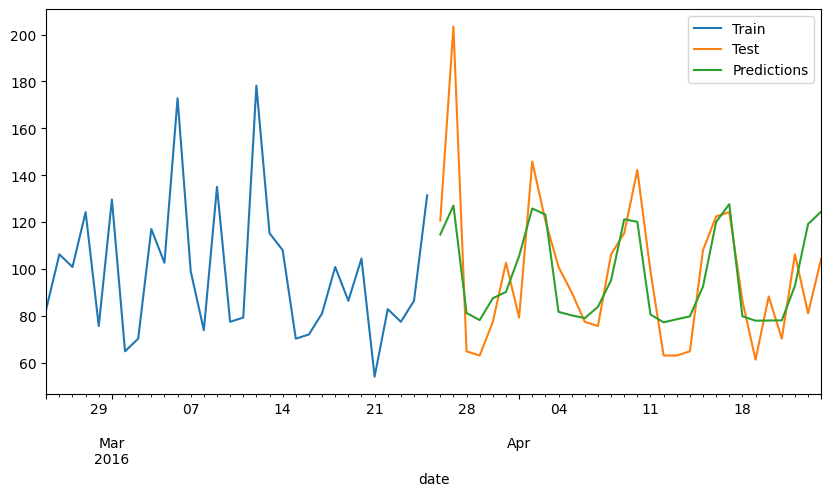

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
y_train[-30:].plot(ax=ax, label='Train')
y_test[-30:].plot(ax=ax, label='Test')
predicciones.plot(ax=ax, label='Predictions')
ax.legend()
plt.show()